# BYU Locating Flagellar Motors

## YOLO Model Training Notebook

This is the third notebook in a series for the BYU Locating Bacterial Flagellar Motors 2025 Kaggle challenge. This notebook handles the training of YOLOv8 object detection models on our prepared dataset.

### Notebook Series:
1. **[Parse Data](https://www.kaggle.com/code/andrewjdarley/parse-data)**: Extracting and preparing 2D slices containing motors to make a YOLO dataset
2. **[Visualize Data](https://www.kaggle.com/code/andrewjdarley/visualize-data)**: Exploratory data analysis and visualization of annotated motor locations
3. **Train YOLO (Current)**: Fine tuning an YOLOv8 object detection model on the prepared dataset
4. **[Submission Notebook](https://www.kaggle.com/code/andrewjdarley/submission-notebook)**: Running inference and generating submission files 

## About this Notebook

This training notebook implements a full YOLOv8 training pipeline for detecting bacterial flagellar motors in tomographic slices. The notebook:

1. **Dataset Configuration**: Sets up and validates the YOLO-format dataset YAML configuration
2. **Model Initialization**: Loads pre-trained YOLOv8 weights for transfer learning
3. **Training Process**: Fine tunes the model with early stopping and periodic checkpoints
4. **Loss Visualization**: Plots training and validation dfl loss curves to monitor progress
5. **Performance Evaluation**: Tests the trained model on random validation samples
6. **Model Export**: Saves the trained weights for use in the submission notebook

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.8 MB/s eta 0:00:00


In [2]:
import os
import torch
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from ultralytics import YOLO
import yaml
import pandas as pd
import json
import torch.nn as nn
from ultralytics import RTDETR
from ultralytics.nn.modules import Conv, C2f
from typing import List, Optional, Dict, Any, Union


# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Define paths for Kaggle environment
yolo_dataset_dir = "/kaggle/input/parse-data/yolo_dataset"
yolo_weights_dir = "/kaggle/working/rtdetr_weights"
yolo_pretrained_weights = "rtdetr-l.pt"  # Path to pre-downloaded weights

# Create weights directory if it doesn't exist
os.makedirs(yolo_weights_dir, exist_ok=True)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
class SelfAttention(nn.Module):
    """Self-attention module for YOLOv8 backbone."""
    
    def __init__(self, channels, reduction_ratio=8):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(channels, channels // reduction_ratio, kernel_size=1)
        self.key = nn.Conv2d(channels, channels // reduction_ratio, kernel_size=1)
        self.value = nn.Conv2d(channels, channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))  # Learnable scaling parameter
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        batch_size, channels, height, width = x.size()
        
        # Reshape for attention computation
        proj_query = self.query(x).view(batch_size, -1, height * width).permute(0, 2, 1)  # B x HW x C'
        proj_key = self.key(x).view(batch_size, -1, height * width)  # B x C' x HW
        
        # Compute attention map
        energy = torch.bmm(proj_query, proj_key)  # B x HW x HW
        attention = self.softmax(energy)  # B x HW x HW
        
        # Apply attention
        proj_value = self.value(x).view(batch_size, -1, height * width)  # B x C x HW
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, channels, height, width)
        
        # Residual connection with learnable scale
        out = self.gamma * out + x
        
        return out


class C2fAttention(C2f):
    """C2f block with added self-attention mechanism."""
    
    def __init__(self, c1, c2, n=1, shortcut=False, g=1, e=0.5):
        # Initialize the parent C2f class
        super().__init__(c1, c2, n, shortcut, g, e)
        # Add the self-attention layer
        self.attention = SelfAttention(c2)
    
    def forward(self, x):
        # Use the original C2f forward pass - access through __call__ or super().forward
        try:
            # First try using direct forward call
            y = super().forward(x)
        except:
            # If that fails, fall back to standard implementation similar to C2f
            y = self.cv2(torch.cat((self.m(self.cv1(x)), x if self.shortcut else self.cv3(x)), 1))
        
        # Add self-attention mechanism
        return self.attention(y)


def apply_attention_to_yolo(model):
    """Apply strong self-attention to early + middle C2f layers of YOLO model for tiny object detection."""
    detection_model = model.model
    backbone_indices = []

    for i, layer in enumerate(detection_model.model):
        if isinstance(layer, C2f):
            backbone_indices.append(i)
    
    print(f"Found {len(backbone_indices)} C2f layers at indices: {backbone_indices}")

    # Modify early, middle, and (optionally) slightly later layers
    indices_to_modify = []
    if len(backbone_indices) >= 4:
        indices_to_modify = [
            backbone_indices[0],  # very early
            backbone_indices[1],  # second C2f (still early)
            backbone_indices[len(backbone_indices)//2],  # middle
        ]
    else:
        indices_to_modify = backbone_indices

    print(f"Modifying C2f layers at indices: {indices_to_modify}")

    for idx in indices_to_modify:
        layer = detection_model.model[idx]
        c1 = layer.cv1.conv.in_channels
        c2 = layer.cv1.conv.out_channels * 2
        n = len(layer.m)
        shortcut = getattr(layer, 'shortcut', True)
        g = layer.cv1.conv.groups

        try:
            e = float(c1 / (layer.cv1.conv.out_channels * 2))
        except:
            e = 0.5
        
        print(f"Creating C2fAttention with params: c1={c1}, c2={c2}, n={n}, shortcut={shortcut}, g={g}, e={e}")
        detection_model.model[idx] = C2fAttention(c1, c2, n, shortcut, g, e)

    return model

Starting YOLO training process...
Directory status:
- Train images dir exists: True
- Val images dir exists: True
- Train labels dir exists: True
- Val labels dir exists: True
Found original dataset.yaml at /kaggle/input/parse-data/yolo_dataset/dataset.yaml
Fixing YAML paths in /kaggle/input/parse-data/yolo_dataset/dataset.yaml
Created fixed YAML at /kaggle/working/fixed_dataset.yaml with path: /kaggle/input/parse-data/yolo_dataset
Using YAML file: /kaggle/working/fixed_dataset.yaml
YAML file contents:
names:
  0: motor
path: /kaggle/input/parse-data/yolo_dataset
train: images/train
val: images/val


Starting YOLO training...
Loading pre-trained weights from: rtdetr-l.pt


100%|██████████| 63.4M/63.4M [00:00<00:00, 246MB/s]


Ultralytics 8.3.121 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=rtdetr-l.pt, data=/kaggle/working/fixed_dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=2, cache=False, device=0, workers=8, project=runs/detect, name=motor_detector, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

100%|██████████| 755k/755k [00:00<00:00, 17.5MB/s]

Overriding class names with single class.


Overriding model.yaml nc=80 with nc=1
WARNING ⚠️ no model scale passed. Assuming scale='l'.

                   from  n    params  module                                       arguments                     
  0                  -1  1     25248  ultralytics.nn.modules.block.HGStem          [3, 32, 48]                   
  1                  -1  6    155072  ultralytics.nn.modules.block.HGBlock         [48, 48, 128, 3, 6]           
  2                  -1  1      1408  ultralytics.nn.modules.conv.DWConv           [128, 128, 3, 2, 1, False]    
  3                  -1  6    839296  ultralytics.nn.modules.block.HGBlock         [128, 96, 512, 3, 6]          
  4                  -1  1      5632  ultralytics.nn.modules.conv.DWConv           [512, 512, 3, 2, 1, False]    
  5                  -1  6   1695360  ultralytics.nn.modules.block.HGBlock         [512, 192, 1024, 5, 6, True, False]
  6                  -1  6   2055808  ultralytics.nn.modules.block.HGBlock         [1024, 192, 1024, 5, 

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.5MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 37.5±16.7 MB/s, size: 345.6 KB)


train: Scanning /kaggle/input/parse-data/yolo_dataset/labels/train... 3262 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3262/3262 [00:20<00:00, 156.54it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/parse-data/yolo_dataset/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 44.1±8.3 MB/s, size: 365.7 KB)


val: Scanning /kaggle/input/parse-data/yolo_dataset/labels/val... 792 images, 0 backgrounds, 0 corrupt: 100%|██████████| 792/792 [00:04<00:00, 168.76it/s]


WARNING ⚠️ val: Cache directory /kaggle/input/parse-data/yolo_dataset/labels is not writeable, cache not saved.
Plotting labels to runs/detect/motor_detector/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 143 weight(decay=0.0), 206 weight(decay=0.0005), 226 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/motor_detector
Starting training for 100 epochs...

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      1/100      12.3G      1.555      1.383     0.3239         20        640: 100%|██████████| 204/204 [03:46<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:16<00:00,  1.50it/s]

                   all        792        792       0.49      0.462      0.404      0.106



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      2/100      12.6G      1.234     0.4887     0.1561         14        640: 100%|██████████| 204/204 [03:44<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.63it/s]


                   all        792        792      0.367      0.223      0.194     0.0382

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      3/100      12.4G      1.311     0.4801     0.1793         18        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.64it/s]

                   all        792        792     0.0655     0.0631    0.00628   0.000767



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      4/100      12.6G       1.32     0.4682     0.1818         26        640: 100%|██████████| 204/204 [03:41<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.63it/s]

                   all        792        792      0.537       0.53      0.416     0.0846



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      5/100      12.6G      1.392     0.4594     0.2088         22        640: 100%|██████████| 204/204 [03:41<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.512      0.545       0.42     0.0905



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      6/100      12.5G      1.146     0.5187     0.1272         22        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.61it/s]

                   all        792        792      0.736      0.717      0.676      0.207



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      7/100      12.6G      1.094     0.5146     0.1166         34        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.61it/s]

                   all        792        792      0.764      0.758      0.725      0.212



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      8/100      12.6G      1.052     0.5345     0.1135         21        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.61it/s]

                   all        792        792      0.781       0.73      0.714      0.253



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      9/100      12.8G       1.05     0.5357     0.1135         21        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.787       0.78      0.793      0.295



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     10/100      12.6G      1.012     0.5323     0.1046         21        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.811      0.792      0.828      0.301



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     11/100      12.7G     0.9933     0.5226     0.1058         23        640: 100%|██████████| 204/204 [03:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.60it/s]

                   all        792        792      0.871      0.804      0.876      0.384



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     12/100      12.6G     0.9886     0.5401        0.1         16        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792       0.84       0.77      0.815      0.305



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     13/100      12.5G     0.9737     0.5417     0.1074         18        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792       0.79      0.696      0.688      0.168



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     14/100      12.6G     0.9607     0.5422    0.09927         29        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.61it/s]

                   all        792        792      0.864      0.841      0.887      0.303



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     15/100      12.8G     0.9297     0.5459    0.09437         25        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.863       0.84      0.881      0.295



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     16/100      12.6G       0.93     0.5287    0.09596         20        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.802      0.803      0.822      0.343



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     17/100      12.7G     0.9423     0.5395     0.0936         28        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.732      0.747      0.709       0.17



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     18/100      12.5G     0.9292     0.5322    0.09421         21        640: 100%|██████████| 204/204 [03:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792       0.79      0.713      0.738      0.303



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     19/100      12.7G     0.9169     0.5332    0.09631         20        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.63it/s]

                   all        792        792      0.841      0.855      0.874       0.29



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     20/100      12.6G     0.8998     0.5277     0.0983         23        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792       0.82      0.806      0.833      0.311



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     21/100      12.6G     0.8896     0.5375    0.08964         26        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.799      0.839      0.865      0.333



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     22/100      12.6G     0.9154     0.5376    0.09647         26        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.825      0.787      0.795      0.342



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     23/100      12.6G     0.8848     0.5277    0.08746         30        640: 100%|██████████| 204/204 [03:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.841      0.857      0.882      0.344



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     24/100      12.6G     0.8929     0.5285     0.0943         23        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.63it/s]

                   all        792        792      0.858      0.832      0.878      0.302



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     25/100      12.6G     0.8881     0.5309    0.09959         21        640: 100%|██████████| 204/204 [03:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.851      0.874      0.888      0.367



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     26/100      12.7G     0.8687     0.5409    0.08633         28        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.861      0.874      0.872       0.26



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     27/100      12.6G      0.872     0.5269    0.08358         30        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.855      0.843      0.869      0.335



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     28/100      12.6G     0.8398     0.5334    0.08302         17        640: 100%|██████████| 204/204 [03:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.806      0.804      0.805      0.333



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     29/100      12.6G     0.8505     0.5327    0.08431         22        640: 100%|██████████| 204/204 [03:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.858       0.87      0.901      0.446



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     30/100      12.7G     0.8224     0.5389    0.07821         23        640: 100%|██████████| 204/204 [03:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.838      0.852      0.872      0.414



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     31/100      12.8G     0.8588     0.5261    0.08222         20        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.826      0.785      0.841      0.394



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     32/100      12.5G     0.8623     0.5455    0.08753         26        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.829      0.858       0.88      0.408



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     33/100      12.5G     0.8603     0.5426    0.08204         23        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.766      0.789      0.783      0.375



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     34/100      12.6G     0.8393     0.5349    0.08147         18        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.833      0.894      0.906      0.421



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     35/100      12.5G     0.8156     0.5391     0.0786         24        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.63it/s]

                   all        792        792      0.835      0.861       0.89      0.332



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     36/100      12.6G     0.8274     0.5265    0.07999         26        640: 100%|██████████| 204/204 [03:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.853      0.826      0.844      0.408



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     37/100      12.5G     0.8074     0.5318    0.07928         31        640: 100%|██████████| 204/204 [03:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.849      0.879      0.864       0.41



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     38/100      12.6G      0.811     0.5325    0.07564         19        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.818      0.867      0.878      0.419



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     39/100      12.6G     0.8056     0.5407    0.07907         25        640: 100%|██████████| 204/204 [03:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.786      0.778      0.803      0.392



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     40/100      12.5G     0.8011     0.5385    0.07819         27        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.877      0.883      0.922      0.445



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     41/100      12.6G     0.8082     0.5356    0.07859         23        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.832      0.856      0.884      0.364



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     42/100      12.6G     0.8046     0.5379    0.07887         23        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.854      0.891      0.908      0.343



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     43/100      12.6G     0.7934     0.5293    0.07591         17        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.862      0.881      0.897      0.352



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     44/100      12.8G     0.7766     0.5401    0.07614         24        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.856      0.899       0.92      0.441



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     45/100      12.5G     0.7913     0.5228     0.0736         25        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.61it/s]

                   all        792        792      0.876      0.907      0.927      0.422



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     46/100      12.6G     0.7755     0.5305    0.07578         20        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.856      0.883      0.887      0.435



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     47/100      12.7G     0.7451     0.5342     0.0657         30        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792       0.83      0.864       0.87      0.457



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     48/100      12.6G     0.7649     0.5322    0.07399         26        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.872      0.872      0.912      0.459



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     49/100      12.6G     0.7772     0.5332    0.07103         13        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.61it/s]

                   all        792        792       0.85      0.877      0.892       0.42



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     50/100      12.6G     0.7581     0.5433    0.06797         22        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.875      0.888      0.909      0.454



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     51/100      12.8G      0.761     0.5397     0.0711         22        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.833      0.896      0.914      0.442



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     52/100      12.8G     0.7372     0.5242    0.06639         26        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.861      0.907      0.914      0.389



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     53/100      12.8G     0.7595     0.5255    0.07561         25        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.61it/s]

                   all        792        792      0.869      0.884      0.921      0.468



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     54/100      12.6G     0.7503     0.5375    0.06656         25        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.888      0.892      0.928      0.493



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     55/100      12.6G     0.7353     0.5352    0.06622         22        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.782      0.835      0.845      0.407



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     56/100      12.6G      0.739     0.5243     0.0665         33        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.63it/s]

                   all        792        792      0.828      0.883      0.895      0.477



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     57/100      12.5G      0.746     0.5265    0.07107         19        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.59it/s]

                   all        792        792      0.886      0.913      0.937      0.475



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     58/100      12.5G     0.7311     0.5262    0.06496         25        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.63it/s]

                   all        792        792      0.824      0.845      0.849       0.46



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     59/100      12.6G     0.7392     0.5219    0.06626         20        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.63it/s]

                   all        792        792      0.855      0.891      0.905      0.386



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     60/100      12.5G     0.7221     0.5323    0.06269         25        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.63it/s]

                   all        792        792      0.875      0.926      0.929       0.44



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     61/100      12.6G     0.7278     0.5321    0.06787         25        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.852       0.91      0.934       0.47



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     62/100      12.5G     0.7161     0.5212    0.06426         34        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792       0.86      0.914      0.934      0.468



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     63/100      12.6G     0.7188     0.5306    0.07569         18        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.831      0.929      0.923      0.471



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     64/100      12.6G     0.7256     0.5174    0.06626         27        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.63it/s]

                   all        792        792      0.875      0.919      0.934      0.446



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     65/100      12.6G     0.7218     0.5172    0.06247         28        640: 100%|██████████| 204/204 [03:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.868      0.902       0.93      0.519



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     66/100      12.6G       0.71     0.5215    0.06267         23        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.63it/s]

                   all        792        792      0.835      0.899      0.907      0.447



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     67/100      12.5G     0.7278     0.5241    0.06569         27        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.873      0.919      0.926      0.449



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     68/100      12.6G     0.7271     0.5201    0.06624         26        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.63it/s]

                   all        792        792      0.864      0.912      0.939       0.46



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     69/100      12.7G     0.6996     0.5258    0.06504         25        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.63it/s]

                   all        792        792      0.871      0.903      0.926      0.413



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     70/100      12.4G     0.6917     0.5205    0.05947         17        640: 100%|██████████| 204/204 [03:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.839        0.9      0.904      0.494



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     71/100      12.8G     0.6968     0.5207    0.05822         20        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.63it/s]

                   all        792        792       0.87      0.912      0.929      0.505



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     72/100      12.5G      0.685     0.5185    0.05823         16        640: 100%|██████████| 204/204 [03:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.61it/s]

                   all        792        792      0.868      0.909       0.93      0.514



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     73/100      12.6G     0.6967     0.5222    0.06039         20        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.884      0.917      0.934      0.384



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     74/100      12.5G     0.6938     0.5197    0.05853         22        640: 100%|██████████| 204/204 [03:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.886      0.919      0.944      0.522



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     75/100      12.6G     0.6811     0.5242    0.05708         20        640: 100%|██████████| 204/204 [03:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.60it/s]

                   all        792        792      0.882      0.899      0.939      0.513



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     76/100      12.6G     0.6807     0.5281    0.06085         25        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.888      0.922      0.949      0.513



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     77/100      12.6G     0.6803     0.5185    0.05432         20        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.61it/s]

                   all        792        792       0.87      0.924      0.925      0.493



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     78/100      12.6G     0.6739     0.5195    0.05524         18        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.61it/s]

                   all        792        792      0.854       0.93      0.938      0.532



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     79/100      12.5G     0.6786     0.5212    0.05838         24        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.872      0.933      0.941      0.522



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     80/100      12.6G     0.6699     0.5145    0.05566         28        640: 100%|██████████| 204/204 [03:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792       0.86      0.917      0.933      0.517



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     81/100      12.5G     0.6569     0.5131    0.05462         22        640: 100%|██████████| 204/204 [03:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.877       0.91      0.937      0.519



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     82/100      12.6G     0.6663     0.5187    0.05671         20        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.881       0.93      0.951      0.555



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     83/100      12.8G     0.6545     0.5151    0.05694         24        640: 100%|██████████| 204/204 [03:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.881      0.917      0.942      0.548



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     84/100      12.8G     0.6756     0.5171    0.05811         21        640: 100%|██████████| 204/204 [03:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.879      0.931      0.941      0.538



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     85/100      12.6G     0.6678     0.5121    0.06128         21        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.879      0.922      0.945       0.51



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     86/100      12.6G     0.6495     0.5213    0.05346         18        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792       0.88      0.938      0.946      0.532



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     87/100      12.5G     0.6432     0.5136    0.05447         18        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.884       0.92      0.944      0.541



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     88/100      12.6G     0.6481     0.5115    0.05957         17        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.60it/s]

                   all        792        792      0.885      0.912      0.942      0.547



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     89/100      12.8G     0.6587     0.5107    0.05635         20        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.874      0.938      0.955      0.565



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     90/100      12.7G     0.6478     0.5066    0.06227         27        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.881      0.916       0.95      0.539


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     91/100      12.6G     0.4573     0.4648    0.03736         13        640: 100%|██████████| 204/204 [03:43<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.61it/s]

                   all        792        792       0.89      0.919      0.947      0.514



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     92/100      12.8G     0.4376     0.4614    0.03496         14        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.888      0.922      0.953      0.532



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     93/100      12.6G      0.433     0.4665    0.03452         14        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.893      0.927       0.96      0.551



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     94/100      12.5G     0.4272     0.4623     0.0336         12        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.61it/s]

                   all        792        792      0.894      0.933      0.969      0.548



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     95/100      12.6G     0.4368     0.4554    0.03431         12        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.893      0.926      0.959      0.556



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     96/100      12.6G      0.428     0.4578    0.03356         12        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.905      0.904      0.958      0.553



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     97/100      12.6G     0.4243     0.4539    0.03247         12        640: 100%|██████████| 204/204 [03:41<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.891       0.92      0.958       0.55



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     98/100      12.8G      0.421     0.4513    0.03277         14        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.60it/s]

                   all        792        792      0.884      0.932      0.957      0.552



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     99/100      12.6G     0.4156     0.4482    0.03174         12        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.896       0.92      0.963      0.558



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    100/100      12.6G     0.4185     0.4522    0.03136         14        640: 100%|██████████| 204/204 [03:42<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]

                   all        792        792      0.899      0.907      0.965      0.567



100 epochs completed in 6.657 hours.
Optimizer stripped from runs/detect/motor_detector/weights/last.pt, 66.1MB
Optimizer stripped from runs/detect/motor_detector/weights/best.pt, 66.1MB

Validating runs/detect/motor_detector/weights/best.pt...
Ultralytics 8.3.121 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
rt-detr-l summary: 302 layers, 31,985,795 parameters, 0 gradients, 103.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:16<00:00,  1.56it/s]


                   all        792        792      0.903      0.904      0.965      0.566


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 15.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/motor_detector
DFL loss columns not found in results CSV
Available columns: ['epoch', 'time', 'train/giou_loss', 'train/cls_loss', 'train/l1_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/giou_loss', 'val/cls_loss', 'val/l1_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']

Training complete!

Running predictions on sample images...

image 1/1 /kaggle/input/parse-data/yolo_dataset/images/val/tomo_ba9b3d_z0138_y0856_x0343.jpg: 640x640 1 item, 48.3ms
Speed: 5.5ms preprocess, 48.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/parse-data/yolo_dataset/images/val/tomo_285d15_z0135_y0391_x0611.jpg: 640x640 1 item, 48.7ms
Speed: 2.9ms preprocess, 48.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/parse-data/yolo_dataset/images/val/tomo_ff505c_z0112_y0816

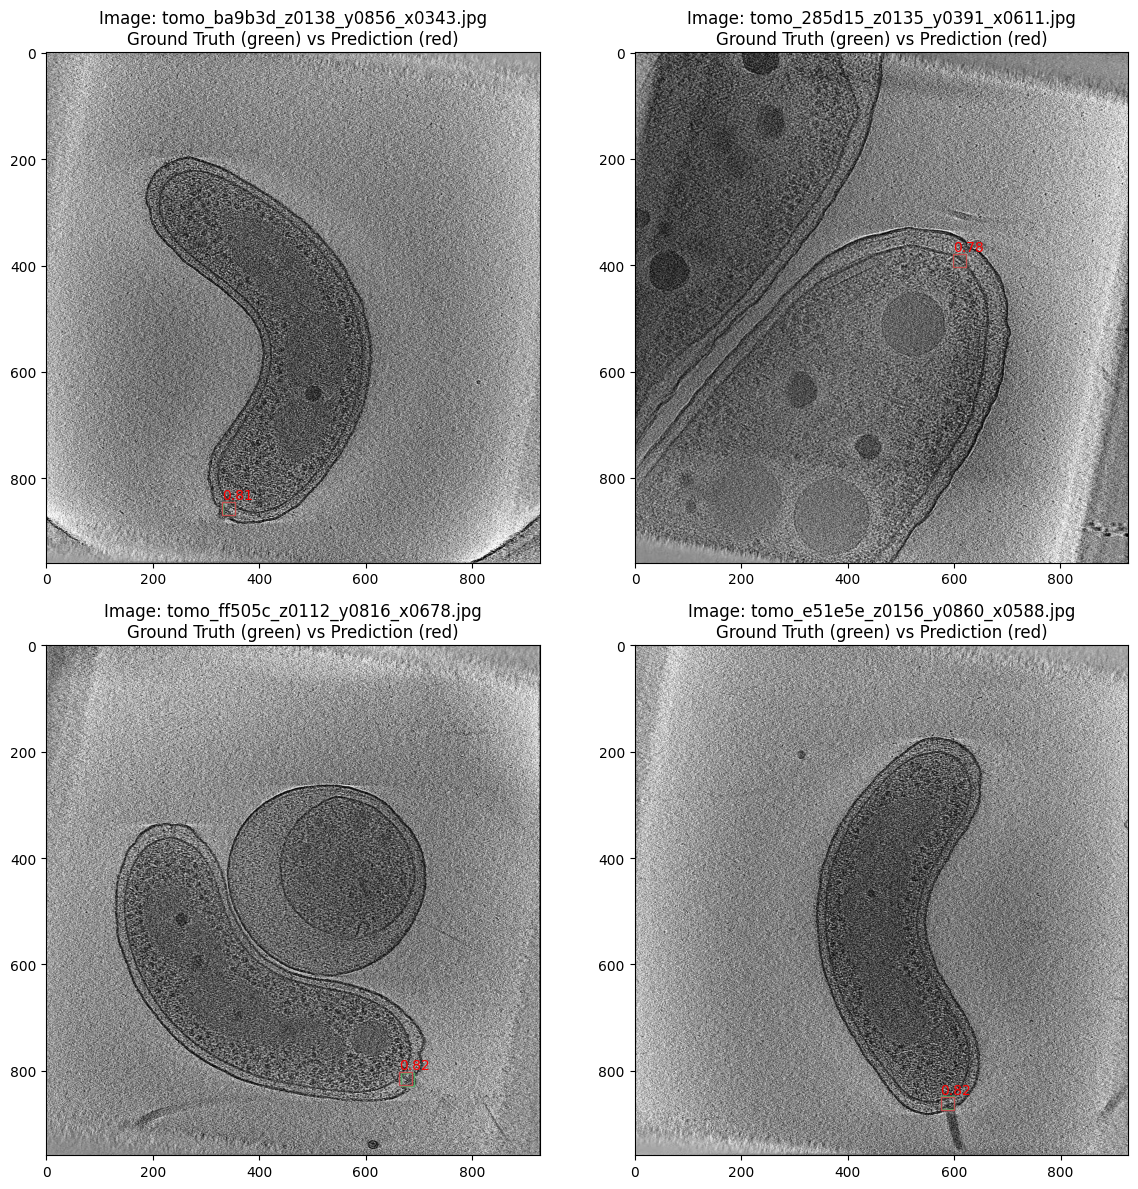

In [4]:
def fix_yaml_paths(yaml_path):
    """
    Fix the paths in the YAML file to match the actual Kaggle directories
    
    Args:
        yaml_path (str): Path to the original dataset YAML file
        
    Returns:
        str: Path to the fixed YAML file
    """
    print(f"Fixing YAML paths in {yaml_path}")
    
    # Read the original YAML
    with open(yaml_path, 'r') as f:
        yaml_data = yaml.safe_load(f)
    
    # Update paths to use actual dataset location
    if 'path' in yaml_data:
        yaml_data['path'] = yolo_dataset_dir
    
    # Create a new fixed YAML in the working directory
    fixed_yaml_path = "/kaggle/working/fixed_dataset.yaml"
    with open(fixed_yaml_path, 'w') as f:
        yaml.dump(yaml_data, f)
    
    print(f"Created fixed YAML at {fixed_yaml_path} with path: {yaml_data.get('path')}")
    return fixed_yaml_path

def plot_dfl_loss_curve(run_dir):
    """
    Plot the DFL loss curves for train and validation, marking the best model
    
    Args:
        run_dir (str): Directory where the training results are stored
    """
    # Path to the results CSV file
    results_csv = os.path.join(run_dir, 'results.csv')
    
    if not os.path.exists(results_csv):
        print(f"Results file not found at {results_csv}")
        return
    
    # Read results CSV
    results_df = pd.read_csv(results_csv)
    
    # Check if DFL loss columns exist
    train_dfl_col = [col for col in results_df.columns if 'train/dfl_loss' in col]
    val_dfl_col = [col for col in results_df.columns if 'val/dfl_loss' in col]
    
    if not train_dfl_col or not val_dfl_col:
        print("DFL loss columns not found in results CSV")
        print(f"Available columns: {results_df.columns.tolist()}")
        return
    
    train_dfl_col = train_dfl_col[0]
    val_dfl_col = val_dfl_col[0]
    
    # Find the epoch with the best validation loss
    best_epoch = results_df[val_dfl_col].idxmin()
    best_val_loss = results_df.loc[best_epoch, val_dfl_col]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plot training and validation losses
    plt.plot(results_df['epoch'], results_df[train_dfl_col], label='Train DFL Loss')
    plt.plot(results_df['epoch'], results_df[val_dfl_col], label='Validation DFL Loss')
    
    # Mark the best model with a vertical line
    plt.axvline(x=results_df.loc[best_epoch, 'epoch'], color='r', linestyle='--', 
                label=f'Best Model (Epoch {int(results_df.loc[best_epoch, "epoch"])}, Val Loss: {best_val_loss:.4f})')
    
    # Add labels and legend
    plt.xlabel('Epoch')
    plt.ylabel('DFL Loss')
    plt.title('Training and Validation DFL Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Save the plot in the same directory as weights
    plot_path = os.path.join(run_dir, 'dfl_loss_curve.png')
    plt.savefig(plot_path)
    
    # Also save it to the working directory for easier access
    plt.savefig(os.path.join('/kaggle/working', 'dfl_loss_curve.png'))
    
    print(f"Loss curve saved to {plot_path}")
    plt.close()
    
    # Return the best epoch info
    return best_epoch, best_val_loss

def train_yolo_model(yaml_path, pretrained_weights_path, epochs=30, batch_size=16, img_size=640, 
                    use_attention=True, yolo_weights_dir='runs/detect', devices=0):
    """
    Train a YOLO model on the prepared dataset with option to use self-attention architecture
    
    Args:
        yaml_path (str): Path to the dataset YAML file
        pretrained_weights_path (str): Path to pre-downloaded weights file
        epochs (int): Number of training epochs
        batch_size (int): Batch size for training
        img_size (int): Image size for training
        use_attention (bool): Whether to use the self-attention architecture
        yolo_weights_dir (str): Directory to save training results
    """
    print(f"Loading pre-trained weights from: {pretrained_weights_path}")
    
    # Load the standard YOLOv8 model
    model = RTDETR(pretrained_weights_path)
    
    # Apply attention mechanism if requested
    # if use_attention:
    #     print("Applying self-attention to YOLOv8 architecture")
    #     try:
    #         model = apply_attention_to_yolo(model)
    #         print("Successfully applied self-attention to model")
    #     except Exception as e:
    #         print(f"Error applying self-attention: {e}")
    #         print("Falling back to standard YOLOv8 architecture")
    #         # Reload the original model to ensure it's in a clean state
    #         model = YOLO(pretrained_weights_path)
    # else:
    #     print("Using standard YOLOv8 architecture")
    
    # Train the model with early stopping
    results = model.train(
        data=yaml_path,
        epochs=epochs,
        batch=batch_size,
        imgsz=img_size,
        project=yolo_weights_dir,
        device=devices,
        name='motor_detector',
        exist_ok=True,
        # patience=10,              # Early stopping if no improvement for 5 epochs
        save_period=2,           # Save checkpoints every 5 epochs
        val=True,                # Ensure validation is performed
        verbose=True,             # Show detailed output during training
        single_cls=True,
        degrees=180,
        translate=0.2,
        shear=2.0,
        perspective=0.001,
        flipud=0.5,
        fliplr=0.5,
        mixup=0.25
    )
    
    # Get the path to the run directory
    run_dir = os.path.join(yolo_weights_dir, 'motor_detector')
    
    # Plot and save the loss curve
    best_epoch_info = plot_dfl_loss_curve(run_dir)
    
    if best_epoch_info:
        best_epoch, best_val_loss = best_epoch_info
        print(f"\nBest model found at epoch {best_epoch} with validation DFL loss: {best_val_loss:.4f}")
    
    return model, results


def predict_on_samples(model, num_samples=4, conf_threshold=0.25):
    """
    Run predictions on random validation samples and display results
    
    Args:
        model: Trained YOLO model
        num_samples (int): Number of random samples to test
    """
    # Get validation images
    val_dir = os.path.join(yolo_dataset_dir, 'images', 'val')
    if not os.path.exists(val_dir):
        print(f"Validation directory not found at {val_dir}")
        # Try train directory instead if val doesn't exist
        val_dir = os.path.join(yolo_dataset_dir, 'images', 'train')
        print(f"Using train directory for predictions instead: {val_dir}")
        
    if not os.path.exists(val_dir):
        print("No images directory found for predictions")
        return
    
    val_images = os.listdir(val_dir)
    
    if len(val_images) == 0:
        print("No images found for prediction")
        return
    
    # Select random samples
    num_samples = min(num_samples, len(val_images))
    samples = random.sample(val_images, num_samples)
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()
    
    for i, img_file in enumerate(samples):
        if i >= len(axes):
            break
            
        img_path = os.path.join(val_dir, img_file)
        
        # Run prediction
        results = model.predict(img_path, conf=conf_threshold, batch=4)[0]
        
        # Load and display the image
        img = Image.open(img_path)
        axes[i].imshow(np.array(img), cmap='gray')
        
        # Draw ground truth box if available (from filename)
        try:
            # This assumes your filenames contain coordinates in a specific format
            parts = img_file.split('_')
            y_part = [p for p in parts if p.startswith('y')]
            x_part = [p for p in parts if p.startswith('x')]
            
            if y_part and x_part:
                y_gt = int(y_part[0][1:])
                x_gt = int(x_part[0][1:].split('.')[0])
                
                box_size = 24
                rect_gt = Rectangle((x_gt - box_size//2, y_gt - box_size//2), 
                              box_size, box_size, 
                              linewidth=1, edgecolor='g', facecolor='none')
                axes[i].add_patch(rect_gt)
        except:
            pass  # Skip ground truth if parsing fails
        
        # Draw predicted boxes (red)
        if len(results.boxes) > 0:
            boxes = results.boxes.xyxy.cpu().numpy()
            confs = results.boxes.conf.cpu().numpy()
            
            for box, conf in zip(boxes, confs):
                x1, y1, x2, y2 = box
                rect_pred = Rectangle((x1, y1), x2-x1, y2-y1, 
                                     linewidth=1, edgecolor='r', facecolor='none')
                axes[i].add_patch(rect_pred)
                axes[i].text(x1, y1-5, f'{conf:.2f}', color='red')
        
        axes[i].set_title(f"Image: {img_file}\nGround Truth (green) vs Prediction (red)")
    
    plt.tight_layout()
    
    # Save the predictions plot
    plt.savefig(os.path.join('/kaggle/working', 'predictions.png'))
    plt.show()

# Check and create a dataset YAML if needed
def prepare_dataset():
    """
    Check if dataset exists and create a proper YAML if needed
    
    Returns:
        str: Path to the YAML file to use for training
    """
    # Check if images exist
    train_images_dir = os.path.join(yolo_dataset_dir, 'images', 'train')
    val_images_dir = os.path.join(yolo_dataset_dir, 'images', 'val')
    train_labels_dir = os.path.join(yolo_dataset_dir, 'labels', 'train')
    val_labels_dir = os.path.join(yolo_dataset_dir, 'labels', 'val')
    
    # Print directory existence status
    print(f"Directory status:")
    print(f"- Train images dir exists: {os.path.exists(train_images_dir)}")
    print(f"- Val images dir exists: {os.path.exists(val_images_dir)}")
    print(f"- Train labels dir exists: {os.path.exists(train_labels_dir)}")
    print(f"- Val labels dir exists: {os.path.exists(val_labels_dir)}")
    
    # Check for original YAML file
    original_yaml_path = os.path.join(yolo_dataset_dir, 'dataset.yaml')
    
    if os.path.exists(original_yaml_path):
        print(f"Found original dataset.yaml at {original_yaml_path}")
        # Fix the paths in the YAML
        return fix_yaml_paths(original_yaml_path)
    else:
        print(f"Original dataset.yaml not found, creating a new one")
        
        # Create a new YAML file
        yaml_data = {
            'path': yolo_dataset_dir,
            'train': 'images/train',
            'val': 'images/train' if not os.path.exists(val_images_dir) else 'images/val',
            'names': {0: 'motor'}
        }
        
        new_yaml_path = "/kaggle/working/dataset.yaml"
        with open(new_yaml_path, 'w') as f:
            yaml.dump(yaml_data, f)
            
        print(f"Created new YAML at {new_yaml_path}")
        return new_yaml_path

# Main execution
def main():
    print("Starting YOLO training process...")
    
    # Prepare dataset and get YAML path
    yaml_path = prepare_dataset()
    print(f"Using YAML file: {yaml_path}")
    
    # Print YAML file contents
    with open(yaml_path, 'r') as f:
        yaml_content = f.read()
    print(f"YAML file contents:\n{yaml_content}")
    
    # Train model
    print("\nStarting YOLO training...")
    model, results = train_yolo_model(
        yaml_path,
        pretrained_weights_path=yolo_pretrained_weights,
        epochs=100,  # Using 30 epochs instead of 100 for faster training
        devices=0,
        use_attention=False
    )
    
    print("\nTraining complete!")
    
    # Run predictions
    print("\nRunning predictions on sample images...")
    predict_on_samples(model, num_samples=4, conf_threshold=0.1)

if __name__ == "__main__":
    main()